<a href="https://colab.research.google.com/github/ankitbit/Advanced_Machine_Learning/blob/master/Assignment%20Reports/Assignment%202/Product_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget 'https://raw.githubusercontent.com/ankitbit/Deep_Learning/master/Assignment%20Reports/Assignment%202/data/cameras.tsv'
! wget 'https://raw.githubusercontent.com/ankitbit/Deep_Learning/master/Assignment%20Reports/Assignment%202/data/clothing.tsv'
! wget 'https://raw.githubusercontent.com/ankitbit/Deep_Learning/master/Assignment%20Reports/Assignment%202/data/home.tsv'

--2018-11-13 16:31:29--  https://raw.githubusercontent.com/ankitbit/Deep_Learning/master/Assignment%20Reports/Assignment%202/data/cameras.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97776 (95K) [text/plain]
Saving to: ‘cameras.tsv’

cameras.tsv         100%[===================>]  95.48K  --.-KB/s    in 0.03s   

2018-11-13 16:31:29 (3.66 MB/s) - ‘cameras.tsv’ saved [97776/97776]

--2018-11-13 16:31:30--  https://raw.githubusercontent.com/ankitbit/Deep_Learning/master/Assignment%20Reports/Assignment%202/data/clothing.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, 

In [0]:
%%capture
! pip install gensim
! pip install nltk

In [0]:
# Importing major libraries
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical


MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300

EMBEDDING_FILE = "GoogleNews-vectors-negative300.bin"
category_index = {"clothing":0, "camera":1, "home-appliances":2}
category_reverse_index = dict((y,x) for (x,y) in category_index.items())

In [68]:
# Reading the dataset
clothing = pd.read_csv("clothing.tsv", sep='\t')
cameras = pd.read_csv("cameras.tsv", sep='\t')
home_appliances = pd.read_csv("home.tsv", sep='\t')
datasets = [clothing, cameras, home_appliances]


# Examination of null values
print("Make sure there are no null values in the datasets")
for data in datasets:
    print("Has null values: ", data.isnull().values.any())

Make sure there are no null values in the datasets
Has null values:  False
Has null values:  False
Has null values:  False


In [0]:
def preprocess(text):
    text= text.strip().lower().split()
    return " ".join(text)
    
for dataset in datasets:
    dataset['title'] = dataset['title'].apply(preprocess)

In [0]:
all_texts = clothing['title'] + cameras['title'] + home_appliances['title']
all_texts = all_texts.drop_duplicates(keep=False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(all_texts)

clothing_sequences = tokenizer.texts_to_sequences(clothing['title'])
electronics_sequences = tokenizer.texts_to_sequences(cameras['title'])
home_appliances_sequences = tokenizer.texts_to_sequences(home_appliances['title'])

clothing_data = pad_sequences(clothing_sequences, maxlen=MAX_SEQUENCE_LENGTH)
electronics_data = pad_sequences(electronics_sequences, maxlen=MAX_SEQUENCE_LENGTH)
home_appliances_data = pad_sequences(home_appliances_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [71]:
word_index = tokenizer.word_index
test_string = "sports action spy pen camera"
print("word\t\tid")
print("-" * 20)
for word in test_string.split():
    print("%s\t\t%s" % (word, word_index[word]))

word		id
--------------------
sports		16
action		13
spy		7
pen		60
camera		2


In [72]:
test_sequence = tokenizer.texts_to_sequences(["sports action camera", "spy pen camera"])
padded_sequence = pad_sequences(test_sequence, maxlen=MAX_SEQUENCE_LENGTH)
print("Text to Vector", test_sequence)
print("Padded Vector", padded_sequence)

Text to Vector [[16, 13, 2], [7, 60, 2]]
Padded Vector [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 16 13  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  7 60  2]]


In [73]:

print("clothing: \t\t", to_categorical(category_index["clothing"], 3))
print("camera: \t\t", to_categorical(category_index["camera"], 3))
print("home appliances: \t", to_categorical(category_index["home-appliances"], 3))

clothing: 		 [1. 0. 0.]
camera: 		 [0. 1. 0.]
home appliances: 	 [0. 0. 1.]


In [74]:
print("clothing shape: ", clothing_data.shape)
print("electronics shape: ", electronics_data.shape)
print("home appliances shape: ", home_appliances_data.shape)

data = np.vstack((clothing_data, electronics_data, home_appliances_data))
category = pd.concat([clothing['category'], cameras['category'], home_appliances['category']]).values
category = to_categorical(category)
print("-"*10)
print("combined data shape: ", data.shape)
print("combined category/label shape: ", category.shape)


clothing shape:  (392721, 30)
electronics shape:  (1347, 30)
home appliances shape:  (11425, 30)
----------
combined data shape:  (405493, 30)
combined category/label shape:  (405493, 3)


In [0]:
VALIDATION_SPLIT = 0.4
indices = np.arange(data.shape[0]) # get sequence of row index
np.random.shuffle(indices) # shuffle the row indexes
data = data[indices] # shuffle data/product-titles/x-axis
category = category[indices] # shuffle labels/category/y-axis
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = category[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = category[-nb_validation_samples:]

In [14]:
! wget 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'

--2018-11-13 13:25:17--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.165.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.165.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  44.0MB/s    in 37s     

2018-11-13 13:25:54 (42.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
! gunzip GoogleNews-vectors-negative300.bin.gz

In [0]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)  


In [76]:
from keras.layers import Embedding
word_index = tokenizer.word_index
nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_layer = Embedding(embedding_matrix.shape[0], # or len(word_index) + 1
                            embedding_matrix.shape[1], # or EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

ValueError: ignored

In [19]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation


model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(150, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(75, 3, padding='valid',activation='relu',strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(150,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           822900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 300)           270300    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 150)            135150    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 75)             33825     
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
__________

In [20]:

model_1 = Sequential()
model_1.add(embedding_layer)
model_1.add(Conv1D(250,3,padding='valid',activation='relu',strides=1))
model_1.add(GlobalMaxPooling1D())
model_1.add(Dense(250))
model_1.add(Dropout(0.2))
model_1.add(Activation('relu'))
model_1.add(Dense(3))
model_1.add(Activation('sigmoid'))
model_1.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           822900    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 250)           225250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 753       
__________

In [22]:
histoy_model = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 243296 samples, validate on 162197 samples
Epoch 1/5
243296/243296 [==============================] - 31s 128us/step - loss: 0.1179 - acc: 0.9743 - val_loss: 0.1072 - val_acc: 0.9774
Epoch 2/5
243296/243296 [==============================] - 30s 125us/step - loss: 0.1098 - acc: 0.9768 - val_loss: 0.1054 - val_acc: 0.9777
Epoch 3/5
243296/243296 [==============================] - 31s 126us/step - loss: 0.1089 - acc: 0.9771 - val_loss: 0.1072 - val_acc: 0.9775
Epoch 4/5
243296/243296 [==============================] - 30s 125us/step - loss: 0.1090 - acc: 0.9773 - val_loss: 0.1063 - val_acc: 0.9779
Epoch 5/5
243296/243296 [==============================] - 31s 128us/step - loss: 0.1092 - acc: 0.9773 - val_loss: 0.1081 - val_acc: 0.9777
Test loss: 0.10809600428579581
Test accuracy: 0.9776752960905566


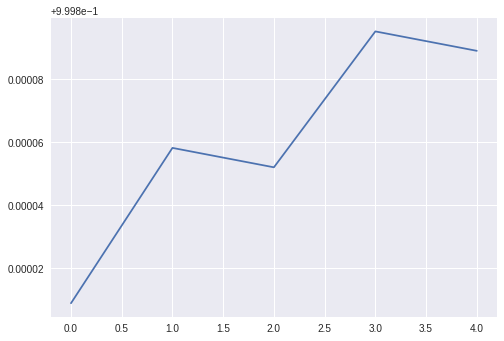

In [55]:
import matplotlib.pyplot as plt
plt.plot(history_model_1.history['val_acc'])

In [25]:
history_model_1 = model_1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)
score = model_1.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 243296 samples, validate on 162197 samples
Epoch 1/5
243296/243296 [==============================] - 21s 87us/step - loss: 0.0030 - acc: 0.9990 - val_loss: 0.0015 - val_acc: 0.9998
Epoch 2/5
243296/243296 [==============================] - 20s 84us/step - loss: 6.3276e-04 - acc: 0.9999 - val_loss: 0.0014 - val_acc: 0.9999
Epoch 3/5
243296/243296 [==============================] - 20s 84us/step - loss: 4.0628e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 4/5
243296/243296 [==============================] - 20s 84us/step - loss: 3.8252e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 5/5
243296/243296 [==============================] - 21s 85us/step - loss: 4.0453e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 0.9999
Test loss: 0.0012650508264004572
Test accuracy: 0.9998890238413781


In [53]:
example_product = "Nikon Coolpix A10 Point and Shoot Camera (Black)"

example_product = preprocess(example_product)
example_sequence = tokenizer.texts_to_sequences([example_product])
example_padded_sequence = pad_sequences(example_sequence, maxlen=MAX_SEQUENCE_LENGTH)

print("-"*10)
print("Predicted category: ", category_reverse_index[model_1.predict_classes(example_padded_sequence, verbose=0)[0]])
print("-"*10)
probabilities = model_1.predict(example_padded_sequence, verbose=0)
probabilities = probabilities[0]
print("Clothing Probability: ",probabilities[category_index["clothing"]] )
print("Camera Probability: ",probabilities[category_index["camera"]] )
print("home appliances probability: ",probabilities[category_index["home-appliances"]] )

----------
Predicted category:  camera
----------
Clothing Probability:  9.572911e-16
Camera Probability:  0.99854654
home appliances probability:  1.149698e-12
